# 그로버 알고리즘

<!-- *예상 QPU 사용량: 4초 (IBM Nairobi에서 테스트됨)* -->

## 배경

진폭 증폭은 여러 고전적 알고리즘에 대해 이차 속도 향상을 얻는 데 사용할 수 있는 범용 양자 알고리즘 또는 서브루틴입니다. [그로버 알고리즘](https://arxiv.org/abs/quant-ph/9605043)은 비정형 검색 문제에서 이러한 속도 향상을 처음으로 입증했습니다. 그로버 검색 문제를 구성하려면 우리가 찾고자 하는 상태로 하나 이상의 계산 기저 상태를 표시하는 오라클 함수와, 표시된 상태의 진폭을 증가시켜 나머지 상태를 억제하는 증폭 회로가 필요합니다.

여기서는 그로버 오라클을 구성하는 방법을 보여주고, Qiskit 회로 라이브러리의 `GroverOperator`를 사용하여 그로버 검색 인스턴스를 쉽게 설정하는 방법을 시연합니다. 런타임 `Sampler` 프리미티브를 통해 그로버 회로를 원활하게 실행할 수 있습니다.

## 요구 사항

이 튜토리얼을 시작하기 전에 다음이 설치되어 있는지 확인하세요:

* Qiskit SDK 1.0 이상, 시각화 지원 포함 (`pip install 'qiskit[visualization]'`)
* Qiskit Runtime (`pip install qiskit-ibm-runtime`) 0.22 이상

## 1단계. 고전적 입력을 양자 문제로 매핑

그로버 알고리즘은 하나 이상의 표시된 계산 기저 상태를 지정하는 [오라클](https://learning.quantum-computing.ibm.com/course/fundamentals-of-quantum-algorithms/grovers-algorithm)이 필요합니다. 여기서 "표시된"이란 위상이 -1인 상태를 의미합니다. 제어-Z 게이트 또는 $N$ 큐비트에 대한 다중 제어 일반화는 $2^{N}-1$ 상태(`'1'`\*$N$ 비트 문자열)를 표시합니다. 이진 표현에서 하나 이상의 `'0'`이 있는 기저 상태를 표시하려면 제어-Z 게이트 앞뒤의 해당 큐비트에 X 게이트를 적용해야 합니다; 이는 해당 큐비트에 대한 개방 제어와 동일합니다. 다음 코드에서는 비트 문자열 표현으로 정의된 하나 이상의 입력 기저 상태를 표시하는 오라클을 정의합니다. `MCMT` 게이트는 다중 제어 Z 게이트를 구현하는 데 사용됩니다.

### 설정

이 튜토리얼에 필요한 소수의 도구를 임포트합니다.

In [1]:
# 내장 모듈
import math

# Qiskit 임포트
from qiskit import QuantumCircuit
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.visualization import plot_distribution

# 로컬 시뮬레이터 샘플러 (IBM 양자 하드웨어 불필요)
from qiskit.primitives import StatevectorSampler

# 시각화용
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [2]:
def grover_oracle(marked_states):
    """여러 표시된 상태에 대한 그로버 오라클 구축

    모든 입력 표시 상태가 동일한 비트 수를 가진다고 가정합니다.

    매개변수:
        marked_states (str 또는 list): 오라클의 표시된 상태

    반환값:
        QuantumCircuit: 그로버 오라클을 나타내는 양자 회로
    """
    if not isinstance(marked_states, list):
        marked_states = [marked_states]
    # 회로의 큐비트 수 계산
    num_qubits = len(marked_states[0])

    qc = QuantumCircuit(num_qubits)
    # 입력 목록의 각 대상 상태를 표시
    for target in marked_states:
        # Qiskit 비트 순서에 맞게 대상 비트 문자열 뒤집기
        rev_target = target[::-1]
        # 비트 문자열에서 모든 '0' 요소의 인덱스 찾기
        zero_inds = [ind for ind in range(num_qubits) if rev_target.startswith("0", ind)]
        # 대상 비트 문자열에 '0' 항목이 있는 곳에
        # 전후 X 게이트(개방 제어)가 적용된 다중 제어 Z 게이트 추가
        qc.x(zero_inds)
        qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)
        qc.x(zero_inds)
        qc.barrier()
    return qc

### 특정 그로버 인스턴스

오라클 함수가 준비되었으니, 그로버 검색의 특정 인스턴스를 정의할 수 있습니다. 이 예제에서는 5큐비트 계산 공간에서 사용 가능한 32개의 상태 중 2개의 계산 상태를 표시합니다:

In [3]:
!pip install pylatexenc


[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


C:\Users\2505002\AppData\Local\Temp\ipykernel_29944\639684635.py:27: DeprecationWarning: The class ``qiskit.circuit.library.generalized_gates.mcmt.MCMT`` is deprecated as of Qiskit 1.4. It will be removed no earlier than 3 months after the release date. Use MCMTGate instead.
  qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)


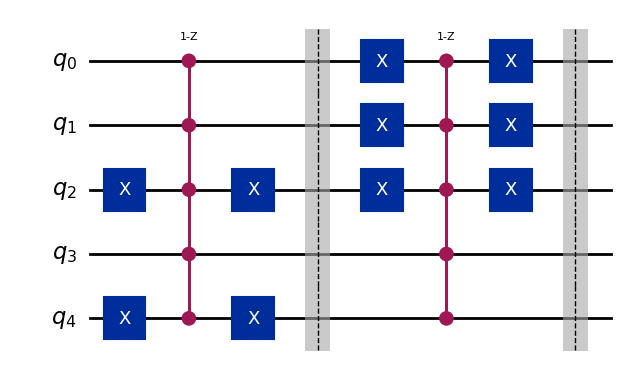

In [4]:
marked_states = ["01011", "11000"]
# 일반적으로 찾고싶은 솔루션이 여러개일 수도 있으니, 두개를 달면 뭐 둘 다 뒤집어준다.
oracle = grover_oracle(marked_states)
oracle.draw(output="mpl", style="iqp")

# 0이 X고, q4가 제일 먼저 오는 것 (5 qubits now)

### 그로버 연산자

기본 제공되는 Qiskit `GroverOperator`는 오라클 회로를 입력받아, 오라클 회로 자체와 오라클에 의해 표시된 상태를 증폭하는 회로로 구성된 회로를 반환합니다. 여기서는 연산자 내부의 게이트를 보기 위해 회로를 `decompose`합니다:

C:\Users\2505002\AppData\Local\Temp\ipykernel_29944\839441854.py:1: DeprecationWarning: The class ``qiskit.circuit.library.grover_operator.GroverOperator`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use qiskit.circuit.library.grover_operator instead.
  grover_op = GroverOperator(oracle)


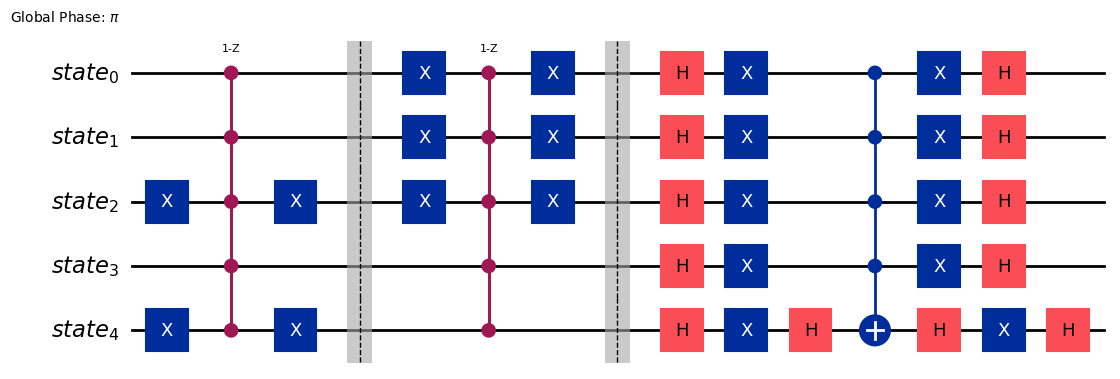

In [5]:
grover_op = GroverOperator(oracle)
grover_op.decompose().draw(output="mpl", style="iqp")

# 빨간 부분 (오른쪽 두개)가 리플렉션을 구현한다.

이 `grover_op` 회로를 반복 적용하면 표시된 상태가 증폭되어, 회로의 출력 분포에서 가장 확률이 높은 비트 문자열이 됩니다. 최적의 적용 횟수는 표시된 상태의 수와 가능한 전체 계산 상태 수의 비율에 의해 결정됩니다:

In [6]:
optimal_num_iterations = math.floor(
    math.pi / (4 * math.asin(math.sqrt(len(marked_states) / 2**grover_op.num_qubits)))
)

In [7]:
optimal_num_iterations

3

### 기하학적 시각화 — "뒤집기와 회전"의 작동 원리

그로버 알고리즘은 두 직교 벡터로 이루어진 2차원 평면에서의 회전으로 기하학적으로 이해할 수 있습니다:

- **|w⟩** — *표시된* (목표) 상태의 정규화된 중첩
- **|s'⟩** — *표시되지 않은* 상태의 정규화된 중첩

초기 균등 중첩 |s⟩는 |s'⟩ 축과 작은 각도 θ₀ = arcsin(√(M/N))을 이룹니다. 각 그로버 반복은 **두 번의 반사**로 구성됩니다:

1. **오라클 (뒤집기)** — |s'⟩ 축에 대해 상태를 반사하여, |w⟩ 성분을 부정합니다. 벡터가 하반면으로 "뒤집힙니다".
2. **확산 (회전)** — 원래 |s⟩ 방향에 대해 상태를 반사하여, 시작점을 *지나* 되돌아옵니다.

결합된 효과는 반복당 |w⟩ 방향으로 **2θ₀**의 순회전입니다. *k*번 반복 후 각도는 (2k+1)θ₀입니다. 이것이 90°에 가까워지면 거의 모든 확률이 표시된 상태에 집중됩니다.

아래에서 각 반단계를 시뮬레이션하고 단위원 위의 궤적을 시각화합니다.

C:\Users\2505002\AppData\Local\Temp\ipykernel_29944\2694598592.py:179: UserWarning: Glyph 44536 (\N{HANGUL SYLLABLE GEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout(w_pad=3)
C:\Users\2505002\AppData\Local\Temp\ipykernel_29944\2694598592.py:179: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout(w_pad=3)
C:\Users\2505002\AppData\Local\Temp\ipykernel_29944\2694598592.py:179: UserWarning: Glyph 48260 (\N{HANGUL SYLLABLE BEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout(w_pad=3)
C:\Users\2505002\AppData\Local\Temp\ipykernel_29944\2694598592.py:179: UserWarning: Glyph 50508 (\N{HANGUL SYLLABLE AL}) missing from font(s) DejaVu Sans.
  plt.tight_layout(w_pad=3)
C:\Users\2505002\AppData\Local\Temp\ipykernel_29944\2694598592.py:179: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  plt.tight_layout(w_pad=3)
C:\Users\2505002\AppData\Local\Temp\ipykernel_29944\2694598592.py:179: UserWarning:

  5 큐비트 그로버 알고리즘  ·  N = 32  ·  M = 2  ·  θ₀ = 14.48°
  최적 반복 횟수: 3

  단계                                         각도      P(표시됨)
  ─────────────────────────────────────────────────────────
  초기 상태 |s⟩                              +14.48°      0.0625
  반복 1: 오라클 (뒤집기)                        -14.48°      0.0625
  반복 1: 확산 (회전)                          +43.43°      0.4727
  반복 2: 오라클 (뒤집기)                        -43.43°      0.4727
  반복 2: 확산 (회전)                          +72.39°      0.9084
  반복 3: 오라클 (뒤집기)                        -72.39°      0.9084
  반복 3: 확산 (회전)                         +101.34°      0.9613


C:\Users\2505002\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 54364 (\N{HANGUL SYLLABLE PYO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\2505002\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\2505002\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 46120 (\N{HANGUL SYLLABLE DOEM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\2505002\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52488 (\N{HANGUL SYLLABLE CO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\2505002\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: 

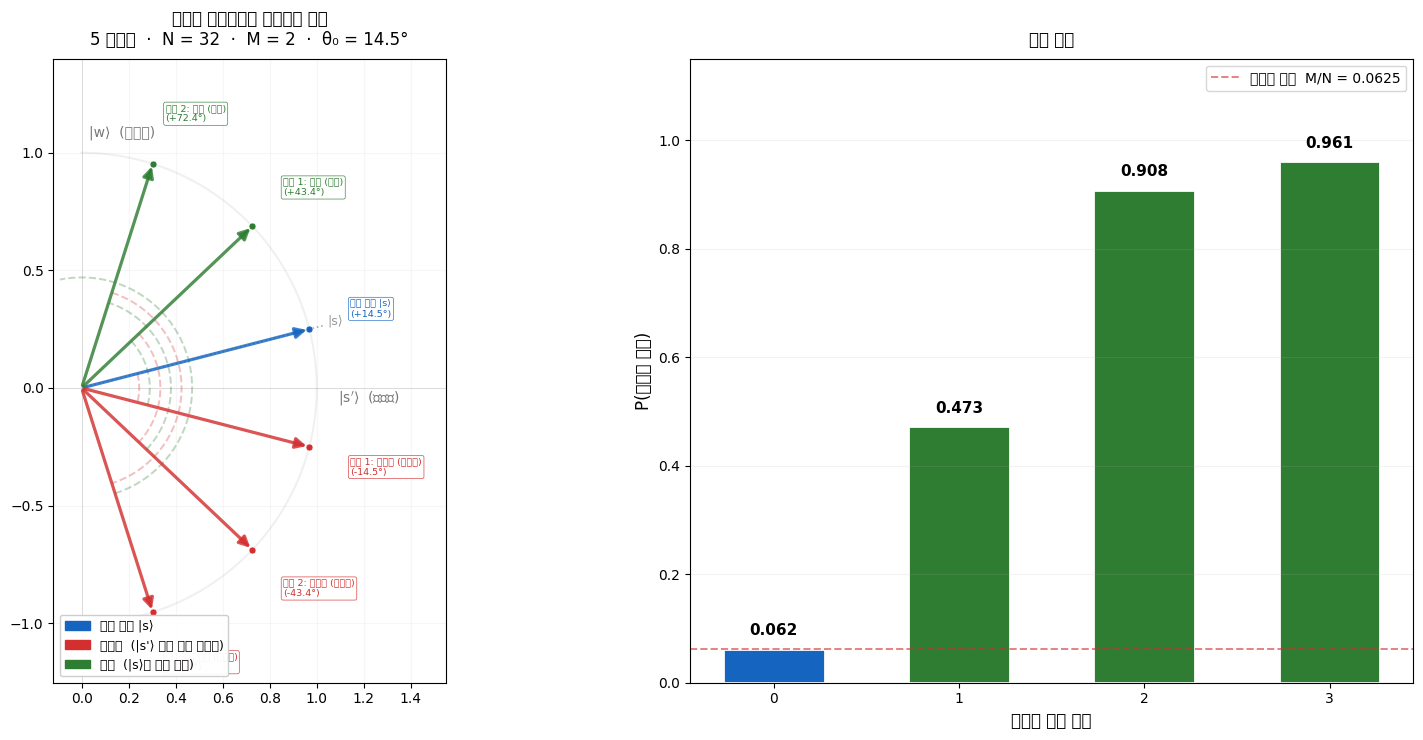

In [8]:
# ══════════════════════════════════════════════════════════════════
# 그로버 알고리즘의 단계별 시뮬레이션
# ══════════════════════════════════════════════════════════════════

n_q = grover_op.num_qubits
N = 2 ** n_q
M = len(marked_states)
theta_0 = np.arcsin(np.sqrt(M / N))

# 표시된 상태 인덱스 (정수 표현)
marked_idx = [int(s, 2) for s in marked_states]

# ── 계산 공간의 기저 벡터 ──
w_vec = np.zeros(N)                        # |w⟩  – 표시된 부분공간
for idx in marked_idx:
    w_vec[idx] = 1.0
w_vec /= np.linalg.norm(w_vec)

s_prime = np.zeros(N)                      # |s'⟩ – 비표시 부분공간
for i in range(N):
    if i not in marked_idx:
        s_prime[i] = 1.0
s_prime /= np.linalg.norm(s_prime)

s_uniform = np.ones(N) / np.sqrt(N)       # |s⟩  – 균등 중첩


def oracle_op(psi):
    """오라클: 표시된 상태의 진폭 부정 (|s'⟩에 대해 반사)."""
    out = psi.copy()
    for idx in marked_idx:
        out[idx] *= -1
    return out


def diffusion_op(psi):
    """확산: 2|s⟩⟨s| − I  (|s⟩에 대해 반사)."""
    return 2 * np.vdot(s_uniform, psi) * s_uniform - psi


def to_2d(psi):
    """(|s'⟩, |w⟩) 평면에 투영 → (x, y)."""
    return (float(np.real(np.vdot(s_prime, psi))),
            float(np.real(np.vdot(w_vec, psi))))


# ── 시뮬레이션 실행, 매 반단계 기록 ──
psi = s_uniform.copy()
traj = []   # (라벨, x, y, 종류)

x, y = to_2d(psi)
traj.append(("초기 상태 |s⟩", x, y, "initial"))

for k in range(optimal_num_iterations):
    psi = oracle_op(psi)
    x, y = to_2d(psi)
    traj.append((f"반복 {k+1}: 오라클 (뒤집기)", x, y, "oracle"))

    psi = diffusion_op(psi)
    x, y = to_2d(psi)
    traj.append((f"반복 {k+1}: 확산 (회전)", x, y, "diffusion"))

# 요약 표 출력
print(f"  {n_q} 큐비트 그로버 알고리즘  ·  N = {N}  ·  M = {M}"
      f"  ·  θ₀ = {np.degrees(theta_0):.2f}°")
print(f"  최적 반복 횟수: {optimal_num_iterations}\n")
print(f"  {'단계':<35s}  {'각도':>8s}  {'P(표시됨)':>10s}")
print("  " + "─" * 57)
for lbl, x, y, _ in traj:
    ang = np.degrees(np.arctan2(y, x))
    print(f"  {lbl:<35s}  {ang:>+8.2f}°  {y**2:>10.4f}")


# ══════════════════════════════════════════════════════════════════
# 그림 1 – 기하학적 보기 + 성공 확률
# ══════════════════════════════════════════════════════════════════

fig, (ax_geo, ax_bar) = plt.subplots(
    1, 2, figsize=(17, 7.5),
    gridspec_kw={"width_ratios": [1.4, 1]})

# ── 왼쪽 패널: 2차원 상태벡터 궤적 ──────────────────────

# 흐린 단위원 호 (상하반부 모두 표시)
t_arc = np.linspace(-np.pi / 2, np.pi / 2, 400)
ax_geo.plot(np.cos(t_arc), np.sin(t_arc), color="black", alpha=0.06, lw=1.5)

# 축
ax_geo.axhline(0, color="gray", lw=0.4, alpha=0.4)
ax_geo.axvline(0, color="gray", lw=0.4, alpha=0.4)
ax_geo.text(1.09, -0.06, r"|s$'$⟩  (비표시)", fontsize=10, color="#777")
ax_geo.text(0.03, 1.07, "|w⟩  (표시됨)", fontsize=10, color="#777")

# |s⟩ 기준 방향
ax_geo.plot([0, 1.06 * np.cos(theta_0)], [0, 1.06 * np.sin(theta_0)],
            ":", color="#aaa", lw=1.2)
ax_geo.text(1.08 * np.cos(theta_0), 1.08 * np.sin(theta_0),
            "|s⟩", fontsize=9, color="#999")

# 색상 팔레트
COL = {"initial": "#1565C0", "oracle": "#D32F2F", "diffusion": "#2E7D32"}

for i, (lbl, x, y, kind) in enumerate(traj):
    c = COL[kind]
    ang_deg = np.degrees(np.arctan2(y, x))

    # 원점에서 화살표
    ax_geo.annotate(
        "", xy=(x, y), xytext=(0, 0),
        arrowprops=dict(arrowstyle="-|>", color=c, lw=2.3,
                        mutation_scale=16, alpha=0.82))
    ax_geo.plot(x, y, "o", color=c, ms=5, zorder=5,
                mec="white", mew=0.4)

    # 화살표 끝에서 방사 방향으로 라벨 배치
    a = np.arctan2(y, x)
    r_off = 1.18
    lx, ly = r_off * np.cos(a), r_off * np.sin(a)
    ha = "left" if np.cos(a) >= 0 else "right"
    va = "bottom" if np.sin(a) >= 0 else "top"
    ax_geo.annotate(
        f"{lbl}\n({ang_deg:+.1f}°)",
        xy=(lx, ly), fontsize=6.8, color=c, ha=ha, va=va,
        bbox=dict(boxstyle="round,pad=0.2", fc="white",
                  ec=c, alpha=0.88, lw=0.5))

    # 이전 상태로부터의 연결 호
    if i > 0:
        px, py = traj[i - 1][1], traj[i - 1][2]
        a1, a2 = np.arctan2(py, px), np.arctan2(y, x)
        r_arc = 0.20 + 0.045 * i
        ts = np.linspace(a1, a2, 80)
        ax_geo.plot(r_arc * np.cos(ts), r_arc * np.sin(ts),
                    "--", color=c, alpha=0.30, lw=1.4)

# 범례
legend_el = [
    mpatches.Patch(color=COL["initial"],   label="초기 상태 |s⟩"),
    mpatches.Patch(color=COL["oracle"],    label="오라클  (|s'⟩ 축에 대해 뒤집기)"),
    mpatches.Patch(color=COL["diffusion"], label="확산  (|s⟩에 대해 반사)"),
]
ax_geo.legend(handles=legend_el, loc="lower left", fontsize=9, framealpha=0.95)

yy = [t[2] for t in traj]
ax_geo.set_xlim(-0.12, 1.55)
ax_geo.set_ylim(min(min(yy) - 0.3, -0.55), 1.40)
ax_geo.set_aspect("equal")
ax_geo.set_title(
    f"그로버 알고리즘의 기하학적 해석\n"
    f"{n_q} 큐비트  ·  N = {N}  ·  M = {M}  ·  "
    f"θ₀ = {np.degrees(theta_0):.1f}°",
    fontsize=12, pad=10)
ax_geo.grid(True, alpha=0.10)

# ── 오른쪽 패널: 반복 횟수별 P(표시됨) ──────────────────

iters_x = list(range(optimal_num_iterations + 1))
p_success = [np.sin((2 * k + 1) * theta_0) ** 2 for k in iters_x]

bar_c = ["#1565C0"] + ["#2E7D32"] * optimal_num_iterations
bars = ax_bar.bar(iters_x, p_success, color=bar_c,
                  edgecolor="white", lw=2, width=0.55)

ax_bar.axhline(M / N, color="#D32F2F", ls="--", lw=1.4, alpha=0.6,
               label=f"무작위 추측  M/N = {M/N:.4f}")

for b, p in zip(bars, p_success):
    ax_bar.text(b.get_x() + b.get_width() / 2, b.get_height() + 0.025,
                f"{p:.3f}", ha="center", fontsize=11, fontweight="bold")

ax_bar.set_xlabel("그로버 반복 횟수", fontsize=12)
ax_bar.set_ylabel("P(표시된 상태)", fontsize=12)
ax_bar.set_title("성공 확률", fontsize=12, pad=10)
ax_bar.set_xticks(iters_x)
ax_bar.set_ylim(0, 1.15)
ax_bar.legend(fontsize=10)
ax_bar.grid(axis="y", alpha=0.15)

plt.tight_layout(w_pad=3)
plt.show()

C:\Users\2505002\AppData\Local\Temp\ipykernel_29944\1307269700.py:49: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\2505002\AppData\Local\Temp\ipykernel_29944\1307269700.py:49: UserWarning: Glyph 51200 (\N{HANGUL SYLLABLE JEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\2505002\AppData\Local\Temp\ipykernel_29944\1307269700.py:49: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\2505002\AppData\Local\Temp\ipykernel_29944\1307269700.py:49: UserWarning: Glyph 53468 (\N{HANGUL SYLLABLE TAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\2505002\AppData\Local\Temp\ipykernel_29944\1307269700.py:49: UserWarning: Glyph 54869 (\N{HANGUL SYLLABLE HWAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\2505002\AppData\Local\Temp\ipykernel_29944\1307269700.py:49: UserWarning: Glyph 47456 (\N{HANGUL SYLLABLE RYUL

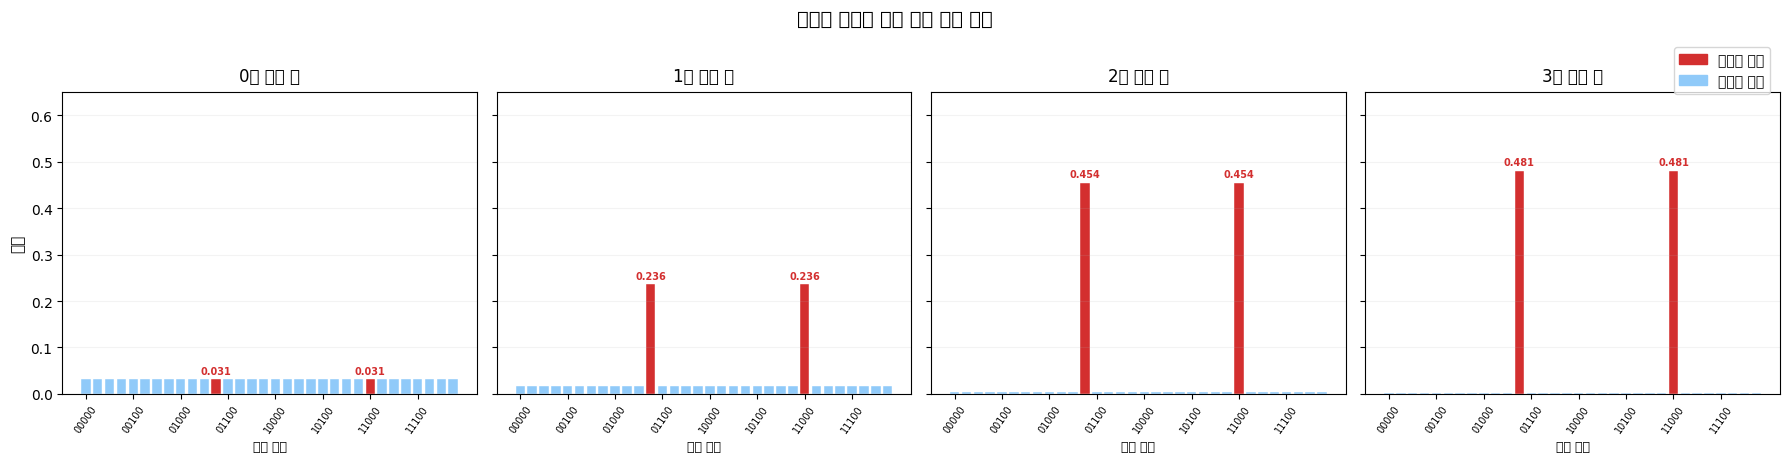

In [9]:
# ══════════════════════════════════════════════════════════════════
# 그림 2 – 각 그로버 반복에서의 전체 확률 분포
# ══════════════════════════════════════════════════════════════════

n_it = optimal_num_iterations
fig2, axes = plt.subplots(1, n_it + 1,
                          figsize=(4.5 * (n_it + 1), 4.5),
                          sharey=True)

psi_snap = s_uniform.copy()
basis_lbl = [format(i, f"0{n_q}b") for i in range(N)]
tick_step = max(1, N // 8)

for k in range(n_it + 1):
    ax = axes[k]
    probs = np.abs(psi_snap) ** 2
    bc = ["#D32F2F" if i in marked_idx else "#90CAF9" for i in range(N)]

    ax.bar(range(N), probs, color=bc, edgecolor="white", lw=0.3)
    ax.set_title(f"{k}회 반복 후",
                 fontsize=12, pad=8)
    ax.set_xlabel("기저 상태", fontsize=9)
    if k == 0:
        ax.set_ylabel("확률", fontsize=11)
    ax.set_xticks(range(0, N, tick_step))
    ax.set_xticklabels([basis_lbl[i] for i in range(0, N, tick_step)],
                       rotation=55, fontsize=7)
    ax.set_ylim(0, 0.65)
    ax.grid(axis="y", alpha=0.15)

    # 표시된 상태 확률 주석
    for idx in marked_idx:
        if probs[idx] > 0.01:
            ax.text(idx, probs[idx] + 0.012, f"{probs[idx]:.3f}",
                    ha="center", fontsize=7, color="#D32F2F",
                    fontweight="bold")

    if k < n_it:
        psi_snap = oracle_op(psi_snap)
        psi_snap = diffusion_op(psi_snap)

fig2.legend(
    handles=[mpatches.Patch(color="#D32F2F", label="표시된 상태"),
             mpatches.Patch(color="#90CAF9", label="비표시 상태")],
    loc="upper right", fontsize=10,
    bbox_to_anchor=(0.99, 0.95))
fig2.suptitle("그로버 반복에 따른 확률 분포 변화",
              fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

### 전체 그로버 회로

완전한 그로버 실험은 각 큐비트에 아다마르 게이트를 적용하는 것으로 시작합니다; 모든 계산 기저 상태의 균등 중첩을 생성한 후, 그로버 연산자(`grover_op`)를 최적 횟수만큼 반복합니다. 여기서는 `QuantumCircuit.power(INT)` 메서드를 사용하여 그로버 연산자를 반복 적용합니다.

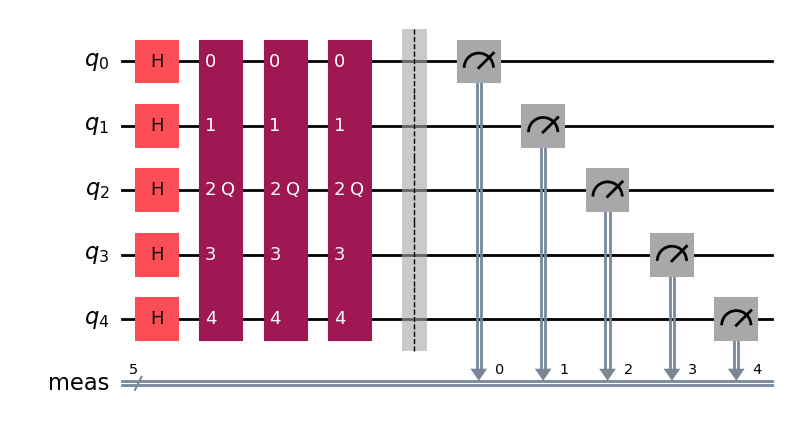

In [10]:
qc = QuantumCircuit(grover_op.num_qubits)
# 모든 기저 상태의 균등 중첩 생성
qc.h(range(grover_op.num_qubits))
# 그로버 연산자를 최적 횟수만큼 적용
qc.compose(grover_op.power(optimal_num_iterations), inplace=True)
# 모든 큐비트 측정
qc.measure_all()
qc.draw(output="mpl", style="iqp")

## 2단계. 양자 실행을 위한 문제 최적화

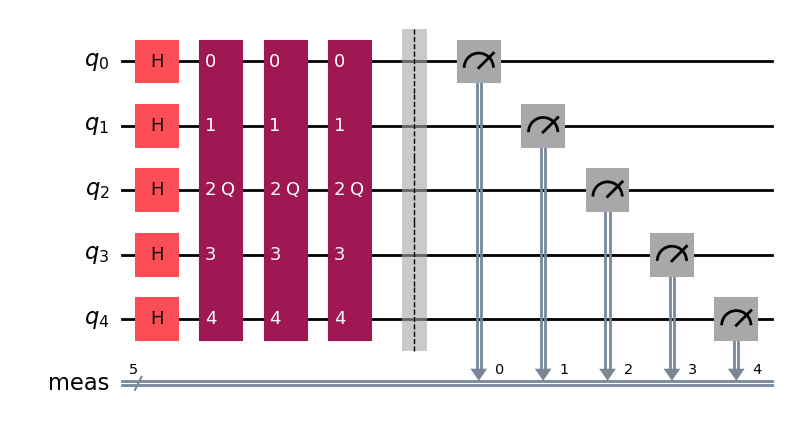

In [11]:
# 로컬 시뮬레이션에는 하드웨어별 트랜스파일이 필요하지 않습니다.
# StatevectorSampler는 임의의 회로를 직접 받을 수 있습니다.
circuit_isa = qc
circuit_isa.draw(output="mpl", idle_wires=False, style="iqp")

## 3단계. Qiskit 프리미티브를 사용한 실행

진폭 증폭은 [`Sampler`](https://docs.quantum-computing.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.SamplerV2) 런타임 프리미티브로 실행하기에 적합한 샘플링 문제입니다.

[Qiskit Runtime `SamplerV2`](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.SamplerV2)의 `run()` 메서드는 `프리미티브 통합 블록(PUB)`의 반복 가능 객체를 받습니다. 샘플러의 경우 각 PUB는 `(회로, 매개변수_값)` 형식의 반복 가능 객체입니다. 그러나 최소한 양자 회로 목록을 받습니다.

샘플러 설정

In [12]:
# 로컬 StatevectorSampler 사용 — 고전 컴퓨터에서 실행, QPU 불필요
sampler = StatevectorSampler(seed=42)

실행

In [13]:
# 로컬에서 실행 — 결과가 즉시 반환됩니다 (대기열 없음)
result = sampler.run([circuit_isa], shots=10000).result()

결과

In [14]:
# 위의 실행 셀에서 이미 결과를 얻었습니다
result

PrimitiveResult([SamplerPubResult(data=DataBin(meas=BitArray(<shape=(), num_shots=10000, num_bits=5>)), metadata={'shots': 10000, 'circuit_metadata': {}})], metadata={'version': 2})

In [15]:
dist = result[0].data.meas.get_counts()
dist

{'11000': 4762,
 '01011': 4824,
 '00101': 13,
 '10000': 21,
 '11010': 15,
 '01010': 12,
 '10100': 17,
 '10011': 15,
 '01001': 14,
 '11101': 12,
 '11111': 19,
 '00100': 17,
 '10110': 14,
 '10010': 15,
 '11100': 12,
 '01000': 8,
 '01111': 10,
 '00011': 18,
 '11110': 13,
 '01101': 16,
 '11011': 12,
 '00001': 14,
 '00000': 15,
 '00111': 11,
 '10101': 18,
 '11001': 17,
 '01100': 10,
 '01110': 14,
 '10111': 14,
 '10001': 9,
 '00110': 10,
 '00010': 9}

In [16]:
# 전체 결과 객체
result

PrimitiveResult([SamplerPubResult(data=DataBin(meas=BitArray(<shape=(), num_shots=10000, num_bits=5>)), metadata={'shots': 10000, 'circuit_metadata': {}})], metadata={'version': 2})

## 4단계. 후처리, 고전적 형식으로 결과 반환

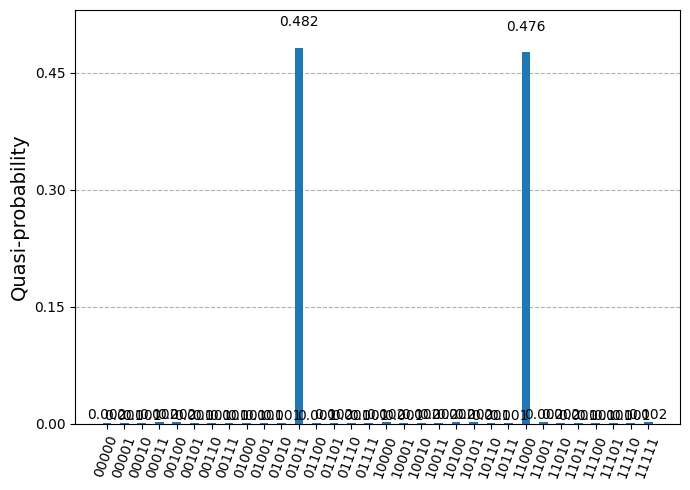

In [17]:
plot_distribution(dist)